<a href="https://colab.research.google.com/github/anjali-rgpt/Autocomplete/blob/master/Neural_Model_with_FastText_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries

%tensorflow_version 2.x
import tensorflow as tf
import numpy as np

In [2]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:

!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!sudo pip install .

import fasttext

Cloning into 'fastText'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 3854 (delta 1), reused 7 (delta 1), pack-reused 3840
Receiving objects: 100% (3854/3854), 8.22 MiB | 10.33 MiB/s, done.
Resolving deltas: 100% (2414/2414), done.
/content/fastText
Processing /content/fastText
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3009801 sha256=adb48243e7a46bb5d432ad845d42d7b2f202cccc840c595826ba71d41ba23844
  Stored in directory: /tmp/pip-ephem-wheel-cache-o77kf_p_/wheels/a1/9f/52/696ce6c5c46325e840c76614ee5051458c0df10306987e7443
Successfully built fasttext


In [4]:
# Import dataset

brown = tf.keras.utils.get_file('brown.txt','http://www.sls.hawaii.edu/bley-vroman/brown.txt')
shake = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
path_to_file = shake
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

print('Text loaded!')





1122304/1115394 [==============================] - 0s 0us/step
Text loaded!


In [5]:
# Model parameters

chars = list(set(text))
words = list(set(word_tokenize(text)))
tokens = word_tokenize(text)

smol_tokens = list(set(tokens))

dim = 100
epochs = 20

In [6]:
# Use FastText to train word embeddings
vecs = fasttext.train_unsupervised(path_to_file, dim=dim)
print('Vectors generated!')

Vectors generated!


In [7]:
# Encode text data into vectors

# encdata = np.asarray([vecs[word] for word in tokens])
# small_encdata = np.asarray([vecs[word] for word in smol_tokens])
encdata = tf.keras.utils.normalize(np.asarray([vecs[word] for word in tokens]))
# print('Text encoded and normalized!')

In [8]:
# Slice encdata into sentences and targets

maxlen = 40
step = 3

sentences, targets = [], []
for i in range(0, len(encdata) - maxlen, step):
  sentences.append(encdata[i: i + maxlen])
  targets.append(encdata[i + maxlen])

In [9]:
# Convert to numpy arrays

X = np.asarray(sentences)
y = np.asarray(targets)

split = len(sentences)*70
split = split//100

In [10]:
# Split into training and test (70-30)

X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [11]:
# Build model

print('Building model...')
model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(128, input_shape=(maxlen, dim)),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(dim)
])

# Compile model

model.compile(loss=tf.keras.losses.CosineSimilarity(axis=1), optimizer='adam', metrics=['mae', 'mse'])
model.summary()

Building model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               12900     
Total params: 134,244
Trainable params: 134,244
Non-trainable params: 0
_________________________________________________________________


In [12]:
print(X_train.shape)
print(y_train.shape)

(59369, 40, 100)
(59369, 100)


In [ ]:
model.fit(X_train, y_train, epochs=20) 


Epoch 1/20
1856/1856 [==============================] - 8s 5ms/step - loss: -0.8206 - mae: 0.4452 - mse: 0.3324
Epoch 2/20
1856/1856 [==============================] - 8s 4ms/step - loss: -0.8249 - mae: 0.9326 - mse: 1.5061
Epoch 3/20
1856/1856 [==============================] - 8s 4ms/step - loss: -0.8263 - mae: 1.7525 - mse: 5.1468
Epoch 4/20
1856/1856 [==============================] - 8s 4ms/step - loss: -0.8272 - mae: 2.8653 - mse: 13.5408
Epoch 5/20
1856/1856 [==============================] - 8s 4ms/step - loss: -0.8282 - mae: 3.9042 - mse: 25.7969
Epoch 6/20
1856/1856 [==============================] - 8s 4ms/step - loss: -0.8289 - mae: 5.3721 - mse: 48.5492
Epoch 7/20
1856/1856 [==============================] - 8s 5ms/step - loss: -0.8296 - mae: 7.0126 - mse: 83.6904
Epoch 8/20
1856/1856 [==============================] - 8s 4ms/step - loss: -0.8301 - mae: 9.1685 - mse: 144.2391
Epoch 9/20
1856/1856 [==============================] - 8s 5ms/step - loss: -0.8307 - mae: 11.2359

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)

In [ ]:
neigh.fit(encdata, tokens)

In [ ]:
import random
# helper function to sample an index from a probability array
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


In [ ]:
# Generates a random seed from given text
def seeder(tokens):
  x = random.randint(0,len(tokens)-maxlen)
  seed = tokens[x:x+maxlen]
  return seed



In [ ]:
# takes in tokens, return encoded next word
def encoder(seed):
  # e = np.asarray([vecs[s] for s in seed])
  e = tf.keras.utils.normalize(np.asarray([vecs[s] for s in seed]))
  e = e.reshape((1,maxlen,dim))
  # print(e, '\n')
  return model.predict(e)



In [ ]:
# generate n next tokens
def predicter(seed, n=10):
  out = seed
  for i in range(n):
    e = encoder(seed)
    d = neigh.predict(e)[0]
    out.append(d)
    seed = out[-maxlen:]
  print(' '.join(out))


In [ ]:
seed = seeder(tokens)
print(' '.join(seed))

predicter(seed, 100)

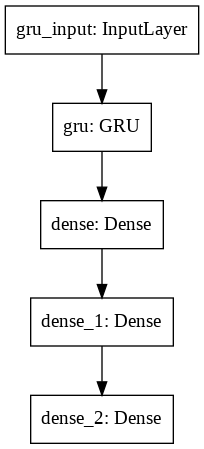

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='fasttextmodel.png')